### Test space for reducing FLOPs in matrix multiplicaiton using a NN

In [12]:
from jaxtyping import Float, Array, Int, PyTree

import jax
import jax.numpy as jnp
from jax import random as jrandom

from jax import scipy as jsp

import equinox as eqx
from equinox import Module

import optax as opt

from src.nn import *

import numpy as np

from matplotlib import pyplot as plt

import streamlit as st
from src.nn import *

In [2]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 3e-4
EPOCHS = 2000
PRINT_EVERY = 100
SEED = 0

In [3]:
# Data
def load_data(b: int = 100, key: jrandom.PRNGKey = jrandom.PRNGKey(0)):
    key, subkey = jrandom.split(key)
    X = jrandom.normal(subkey, (b, 2, 10, 10))
    Y = X[:, 0] @ X[:, 1]

    return X, Y


In [4]:
# Evaluation and Training
def loss(model: NN, x: Float[Array, "b 2 10 10"], y: Float[Array, "b 10 10"]) -> Float[Array, ""]:
    y_pred = jax.vmap(model)(x[:, 0], x[:, 1])
    # return jnp.mean((y - y_pred) ** 2)
    # return cross_entropy(y, y_pred)
    return jnp.linalg.norm(y - y_pred) # frobenius norm by default

def cross_entropy(y: Float[Array, "b 10 10"], y_pred: Float[Array, "b 10 10"]) -> Float[Array, ""]:
    return -jnp.mean(y * jnp.log(y_pred))

def accuracy(y: Float[Array, "b 10 10"], y_pred: Float[Array, "b 10 10"]) -> Float[Array, ""]:
    return jnp.mean(y == y_pred)

def evaluate(model: NN, b: int = 100, key: jrandom.PRNGKey = jrandom.PRNGKey(0)) -> Float[Array, ""]:
    X, Y = load_data(b, key)
    return loss(model, X, Y)

def train(
        model: NN,
        optim: opt.GradientTransformation,
        steps: int,
        print_every: int
) -> NN:
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def step(
        model: NN,
        opt_state: PyTree,
        x: Float[Array, "b 2 10 10"],
        y: Float[Array, "b 10 10"]
    ) -> NN:
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
        updates, opt_step = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_step, loss_value
    
    def infinite_trainloader():
        while True:
            X, Y = load_data(BATCH_SIZE)
            yield X, Y

    for s, (x, y) in zip(range(steps), infinite_trainloader()):
        model, opt_state, loss_value = step(model, opt_state, x, y)

        if s % print_every == 0 or s == steps - 1:
            print(f"Step {s}, Loss: {loss_value}")

    return model


### Initialize and train the model

In [ ]:
print("Training CNN")

net = CNN()

print("Network parameters: ", net.param_count(), "\n")

net = train(net, opt.adam(LEARNING_RATE), EPOCHS, PRINT_EVERY)

plt.plot(net.layer_singular_values(5))
plt.yscale('log')
plt.show()

print("\nSplitting layer 5")
net.split_layer(5, 25)
print("\nNetwork parameters: ", net.param_count(), "\n")

net = train(net, opt.adam(LEARNING_RATE), 2*EPOCHS, PRINT_EVERY)


In [ ]:
print(net)

In [ ]:
plt.plot(net.layer_singular_values(-1))
plt.yscale('log')
plt.show()

In [ ]:
net.split_layer(-1, 85)

net = train(net, opt.adam(LEARNING_RATE/10.), 2*EPOCHS, PRINT_EVERY)

In [ ]:
print(net)

In [ ]:
print(net.layers[-1].param_count())

### Try out a matrix vector product with a 100x100 Toeplitz matrix

In [3]:
class Toeplitz(NN):
    '''
    A CNN to approximate a Toeplitz matrix with diagonals [1, -2, 1]
    on the sub, main, and super diagonals, respectively.
    '''
    
    res_layer: Float[Array, "1 100"]

    def __init__(self, key: Optional[jrandom.PRNGKey] = jrandom.PRNGKey(0)):
        
        keys = jrandom.split(key, 6)

        self.layers = [
            eqx.nn.Linear(100, 100, key=keys[0]), # output: 1x100
            eqx.nn.Conv1d(1, 1, kernel_size=3, stride=3, key=keys[1], padding_mode='REFLECT'),  # output: 1x33
            jax.nn.relu,
            eqx.nn.Conv1d(1, 1, kernel_size=3, stride=1, key=keys[2], padding_mode='REFLECT'),  # output: 1x31
            jax.nn.relu,
            eqx.nn.Linear(31, 256, key=keys[3]),  # output: 1x256
            jax.nn.relu,
            eqx.nn.Linear(256, 100, key=keys[4])  # output: 1x100
        ]

        self.res_layer = eqx.nn.Linear(100, 100, key=keys[5])

    def __call__(self, x: Float[Array, "b 100"]) -> Float[Array, "b 100"]:
        r = self.res_layer(x)
        
        x = self.layers[0](x)
        x = jnp.expand_dims(x, 0)
        # convolutional layers
        x = self.layers[1](x)
        x = self.layers[2](x)
        x = self.layers[3](x)
        x = self.layers[4](x)
        # linear layers
        x = jnp.reshape(x, (x.shape[-1],))
        for layer in self.layers[5:]:
            x = layer(x)
        
        x = x + r

        return x


In [4]:
# Data
def load_data(b: Optional[int] = 100, key: jrandom.PRNGKey = jrandom.PRNGKey(0)):
    key, subkey = jrandom.split(key)

    c = jnp.zeros((100,))
    c = c.at[0].set(-2.)
    c = c.at[1].set(1.)

    r = jnp.zeros((100,))
    r = r.at[0].set(-2.)
    r = r.at[1].set(1.)

    A = jsp.linalg.toeplitz(c, r)
    
    x = jrandom.normal(subkey, (b, 100))
    Y = A @ x[:, ].T

    return x, Y

In [5]:
# Evaluation and Training
def loss(model: NN, x: Float[Array, "b 100"], y: Float[Array, "b 100"]) -> Float[Array, ""]:
    y_pred = jax.vmap(model)(x)
    return jnp.linalg.norm(y.T - y_pred) # 2-norm by default for vectors

def evaluate(model: NN, b: int = 100, key: jrandom.PRNGKey = jrandom.PRNGKey(0)) -> Float[Array, ""]:
    X, Y = load_data(b, key)
    return loss(model, X, Y)

def train(
        model: NN,
        optim: opt.GradientTransformation,
        steps: int,
        print_every: int
) -> NN:
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def step(
        model: NN,
        opt_state: PyTree,
        x: Float[Array, "b 2 10 10"],
        y: Float[Array, "b 10 10"]
    ) -> NN:
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
        updates, opt_step = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_step, loss_value
    
    def infinite_trainloader():
        while True:
            X, Y = load_data(BATCH_SIZE)
            yield X, Y

    for s, (x, y) in zip(range(steps), infinite_trainloader()):
        model, opt_state, loss_value = step(model, opt_state, x, y)

        if s % print_every == 0 or s == steps - 1:
            print(f"Step {s}, Loss: {loss_value}")

    return model


In [7]:
net = Toeplitz()

print("Network parameters: ", net.param_count(), "\n")

net = train(net, opt.adam(LEARNING_RATE), int(1.5*EPOCHS), PRINT_EVERY)

Network parameters:  54100 

Step 0, Loss: 207.3179473876953
Step 100, Loss: 179.8798370361328
Step 200, Loss: 157.07521057128906
Step 300, Loss: 137.0595245361328
Step 400, Loss: 119.28660583496094
Step 500, Loss: 103.46369934082031
Step 600, Loss: 89.37133026123047
Step 700, Loss: 76.8233871459961
Step 800, Loss: 65.64781951904297
Step 900, Loss: 55.68010330200195
Step 1000, Loss: 46.76640319824219
Step 1100, Loss: 38.76856231689453
Step 1200, Loss: 31.567745208740234
Step 1300, Loss: 25.067419052124023
Step 1400, Loss: 19.196441650390625
Step 1500, Loss: 13.911577224731445
Step 1600, Loss: 9.198027610778809
Step 1700, Loss: 5.073873519897461
Step 1800, Loss: 1.635018229484558
Step 1900, Loss: 0.12071845680475235
Step 2000, Loss: 0.056409165263175964
Step 2100, Loss: 0.044170573353767395
Step 2200, Loss: 0.04645336791872978
Step 2300, Loss: 0.044701896607875824
Step 2400, Loss: 0.027774952352046967
Step 2500, Loss: 0.02707802504301071
Step 2600, Loss: 0.035065583884716034
Step 2700, 

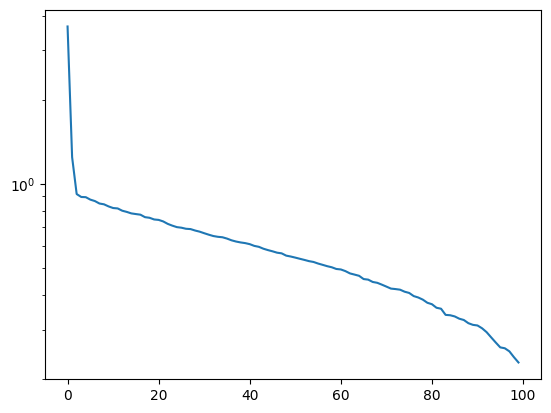

In [8]:
plt.plot(net.layer_singular_values(-1))
plt.yscale('log')
plt.show()

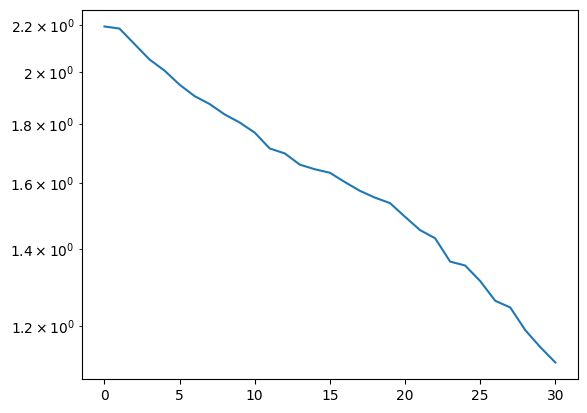

In [9]:
plt.plot(net.layer_singular_values(-3))
plt.yscale('log')
plt.show()

Maybe we can reduce the number of parameters in the last layer.

In [10]:
net.split_layer(-1, 10)

print("New parameter count: ", net.param_count())

net = train(net, opt.adam(LEARNING_RATE/10.), int(1.5*EPOCHS), PRINT_EVERY)

New parameter count:  32060
Step 0, Loss: 1.723635196685791
Step 100, Loss: 0.3318324685096741
Step 200, Loss: 0.01981212943792343
Step 300, Loss: 0.003721330314874649
Step 400, Loss: 0.002792930696159601
Step 500, Loss: 0.002525493735447526
Step 600, Loss: 0.0023241129238158464
Step 700, Loss: 0.001577903749421239
Step 800, Loss: 0.001996465492993593
Step 900, Loss: 0.0018682109657675028
Step 1000, Loss: 0.0022578660864382982
Step 1100, Loss: 0.0018558867741376162
Step 1200, Loss: 0.001772502320818603
Step 1300, Loss: 0.0019033728167414665
Step 1400, Loss: 0.0018756272038444877
Step 1500, Loss: 0.0026477635838091373
Step 1600, Loss: 0.0017519822577014565
Step 1700, Loss: 0.0018641072092577815
Step 1800, Loss: 0.0019455121364444494
Step 1900, Loss: 0.0018292390741407871
Step 2000, Loss: 0.001819936907850206
Step 2100, Loss: 0.001890636165626347
Step 2200, Loss: 0.0017916170181706548
Step 2300, Loss: 0.00185407605022192
Step 2400, Loss: 0.001843062462285161
Step 2500, Loss: 0.0018207357

Around a 40% reduction isn't bad, but the accuracy still isn't very good.